<a href="https://colab.research.google.com/github/Andribi/A2MF_AP/blob/main/A2MF_AP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A2MF_AP

Multimodal face synthesis based on Att2MFace https://arxiv.org/abs/2104.04362 

In [2]:
# IMPORTS 

from keras.layers import Conv2D, Input, Dense, UpSampling2D, AveragePooling2D, Reshape, add
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import pandas as pd
import cv2 as cv
import keras
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# GLOBAL VARIABLES

# dataset path
DS_PATH = '/content/A2MF_AP/fairface'

# train labels path
TRAIN_LABELS_PATH = "fairface_label_train.csv"

# validation labels path
VAL_LABELS_PATH = "fairface_label_val.csv"

# size of noise vector
LATENT_DIM_GAN = 512 

# dimension of images
SPATIAL_DIM = 256

# size of attributes
ATT_SIZE = 3

# number of c modalities
C = 2

# real dimention of images
REAL_DIM = 224 

# number of epochs 
EPOCHS = 50

# number of img for batch
BATCH_SIZE = 16

# seed for shuffle
SEED = 123

## Data analysis

In [4]:
# FAIRFACE CLONE

import os

!git clone https://github.com/Andribi/A2MF_AP.git
%cd A2MF_AP/fairface/ 

fatal: destination path 'A2MF_AP' already exists and is not an empty directory.
/content/A2MF_AP/fairface


In [5]:
# DATA LOAD

fairface_train = pd.read_csv(TRAIN_LABELS_PATH)
fairface_val = pd.read_csv(VAL_LABELS_PATH)
fairface = pd.concat([fairface_train, fairface_val])

fairface.head(5)

,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True


Total number of images in Fairface: 97698
Total number of images in Fairface Train: 86744
Total number of images in Fairface Validation: 10954


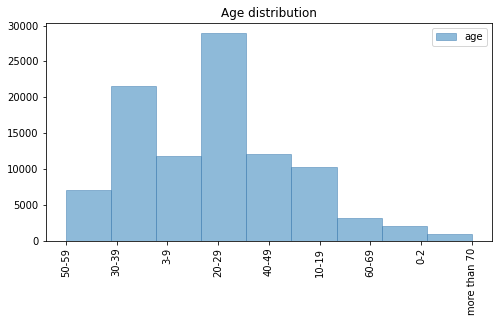

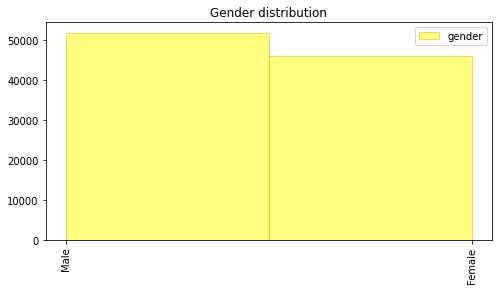

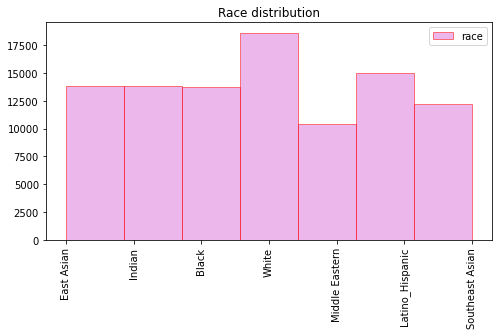

In [6]:
# DISTRIBUTIONS

print('Total number of images in Fairface: ' + str(fairface.shape[0]))
print('Total number of images in Fairface Train: ' + str(fairface_train.shape[0]))
print('Total number of images in Fairface Validation: ' + str(fairface_val.shape[0]))

age = fairface["age"]
age_bins=len(age.value_counts())

gender = fairface["gender"]
gender_bins=len(gender.value_counts())

race = fairface["race"]
race_bins=len(race.value_counts())

age.hist(bins=age_bins, figsize=[8,4], xrot=90, edgecolor='steelblue', linewidth=1, grid=False, alpha=0.5, legend=True)
plt.title('Age distribution')
plt.show()

gender.hist(bins=gender_bins, figsize=[8,4], xrot=90, edgecolor='orange', linewidth=1, grid=False, alpha=0.5, legend=True, color='yellow')
plt.title('Gender distribution')
plt.show()

race.hist(bins=race_bins, figsize=[8,4], xrot=90, edgecolor='red', linewidth=1, grid=False, alpha=0.5, legend=True, color='orchid')
plt.title('Race distribution')
plt.show()

In [7]:
# MISSING VALUES

print('Percentage of missing values:', round((fairface.isna().sum().sum() / fairface.shape[0]) * 100 , 2), '%')

Percentage of missing values: 0.0 %


In [8]:
# ENCODING

enc_fairface = fairface.drop(columns='service_test')
enc_fairface_train = fairface_train.drop(columns='service_test')
enc_fairface_val = fairface_val.drop(columns='service_test')

def encode_dataset(df):
  """
  Function to encode dataframe using One Hot encoding

  Parameters
  ----------
  df (DataFrame) :  A dataframe with names and attributes of a specific dataset 
                    of images

  Returns
  -------
  df (DataFrame) :  Encoded DataFrame
  """

  attr = df.drop(columns='file')
  names = pd.DataFrame(df['file'])  
  
  enc_df = pd.get_dummies(attr, dtype=int)
  enc_df = enc_df.drop(columns='gender_Female')
  df = pd.concat([names, enc_df], axis=1)
  
  print(df.shape)
  return df

def _sk(x):
  """ 
  Function to transform a path for visual images in a path for sketch images

  Parameters
  ----------
  x (str) :  Path in input (example: 'val/1.jpg' or 'train/1.jpg')

  Returns
  -------
  x (str) :  Transformd path (example: 'val_sk/1.jpg' or 'train_sk/1.jpg')
  """

  if 'train' in x:
    x = x[:5] + '_sk' + x[5:]
  if 'val' in x:
    x = x[:3] + '_sk' + x[3:]
  return x 


ff_df = encode_dataset(enc_fairface).replace(0, -1)

train_df = encode_dataset(enc_fairface_train).replace(0, -1)

val_df = encode_dataset(enc_fairface_val).replace(0, -1)

train_sk_df = train_df.copy()
train_sk_df['file'] = train_sk_df['file'].apply(_sk)

val_sk_df = val_df.copy()
val_sk_df['file'] = val_sk_df['file'].apply(_sk)

val_sk_df.head()

(97698, 18)
(86744, 18)
(10954, 18)


,file,age_0-2,age_10-19,age_20-29,age_3-9,age_30-39,age_40-49,age_50-59,age_60-69,age_more than 70,gender_Male,race_Black,race_East Asian,race_Indian,race_Latino_Hispanic,race_Middle Eastern,race_Southeast Asian,race_White
0,val_sk/1.jpg,-1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,-1,-1,-1
1,val_sk/2.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1
2,val_sk/3.jpg,-1,-1,-1,-1,1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1
3,val_sk/4.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1
4,val_sk/5.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,-1


## Dataset

In [9]:
# DATASET CREATION USING TENSORFLOW

def parse_function(filename, label):
  """ 
  Function to open, decode in jpeg, convert in float and resize an image 

  Parameters
  ----------
  filename :  Name of the image 
  label    :  Attributs relative to the image

  Returns
  -------
  image (EagerTensor)    :  Opened and parsed image 
  label (EagerTensor)    :  Attributes relative to the image
  filename (EagerTensor) :  Name of the image
  """

  image = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [SPATIAL_DIM, SPATIAL_DIM])
  return image, label, filename

def create_ds(df):
  """
  Function to create a Tensorflow BatchDataset from a Pandas dataframe. 
  There are three elements in the dataset: images, labels and filenames. 
  The dataset is divided in batches of BATCH_SIZE elements and is shuffled based
  on SEED. 

  Parameters
  ----------
  df (DataFrame) :  A dataframe with names and attributes of a specific dataset 
                    of images

  Returns
  -------
  dataset (BatchDataset) :  Tensorflow Batch Dataset
  """

  filenames = df['file'].values
  labels = df.drop(columns='file').values
  dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
  dataset = dataset.map(parse_function)
  # dataset = dataset.shuffle(buffer_size=df.shape[0], seed=SEED)
  dataset = dataset.batch(BATCH_SIZE)
  # dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

train_ds = create_ds(train_df)
val_ds = create_ds(val_df)
train_sk_ds = create_ds(train_sk_df)
val_sk_ds = create_ds(val_sk_df)

print('Train batches: ', len(train_ds))
print('Train Sketch batches: ', len(train_sk_ds))
print('Validation batches: ', len(val_ds))
print('Validation Sketch batches: ', len(val_sk_ds))

Train batches:  5422
Train Sketch batches:  5422
Validation batches:  685
Validation Sketch batches:  685


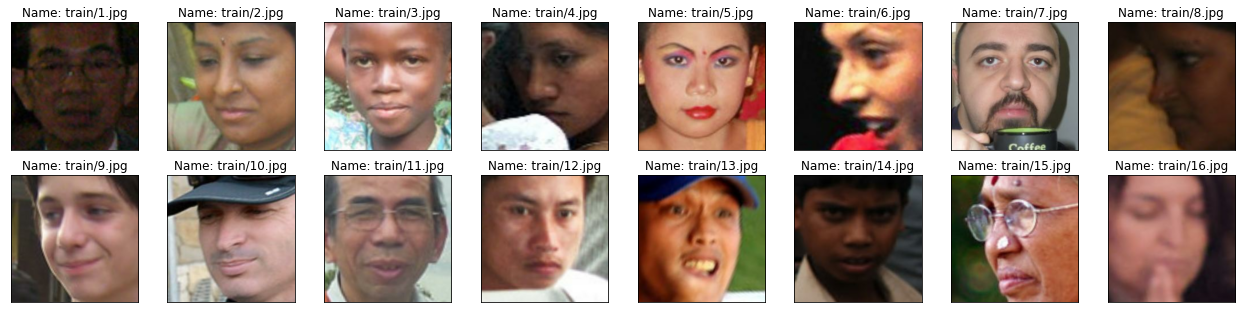

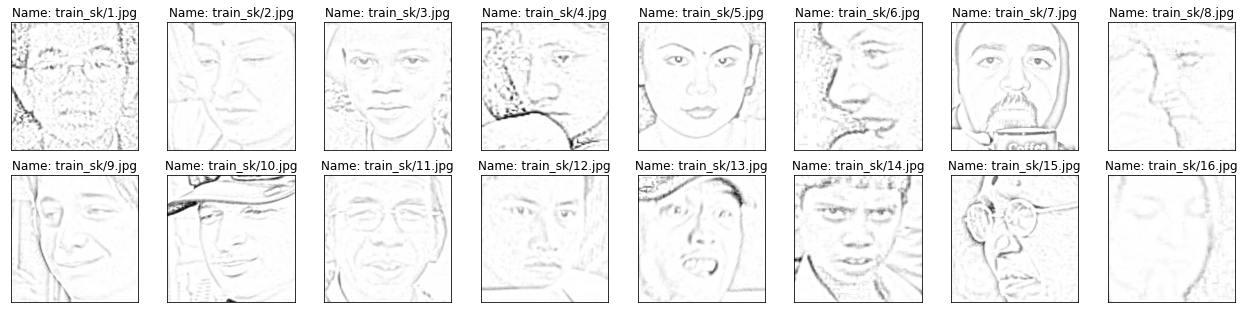

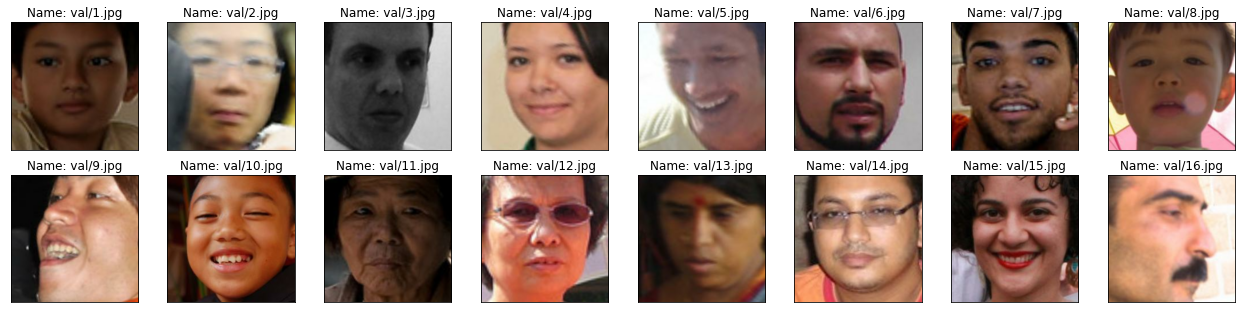

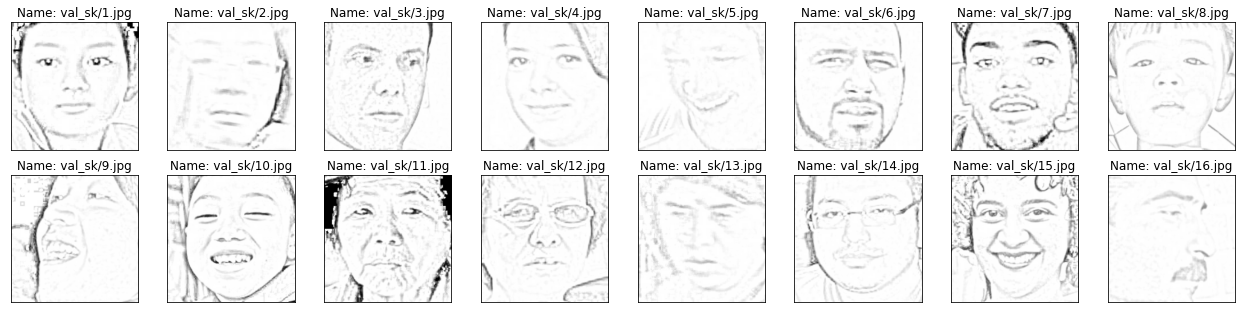

In [22]:
# IMAGE IN DATASET VISUALIZATION

def view_image(ds):
  """
  Visualize images of a Batch Dataset

  Parameters
  ----------
  ds (BatchDataset) :  A batch dataset of images containing image, label, name
  """

  image, label, name = next(iter(ds)) 
  image = image.numpy()
  label = label.numpy()
  name = name.numpy()
  fig = plt.figure(figsize=(22, 22))
  for i in range(16):
      ax = fig.add_subplot(8, 8, i+1, xticks=[], yticks=[])
      ax.imshow(image[i])
      ax.set_title(f"Name: {str(name[i],'utf-8')}")

view_image(train_ds)
view_image(train_sk_ds)
view_image(val_ds)
view_image(val_sk_ds)

## Image Generation

In [ ]:
# GENERATOR

def build_generator(latent_dim, autentication_vector, modalities):
  ''' add doc '''

  # Pixelwise feature vector normalization.
  def pixel_norm(x, epsilon=1e-8):
    ''' add doc '''
    return x * tf.math.rsqrt(tf.reduce_mean(tf.square(x), axis=1, keepdims=True) + epsilon)

  def add_multi_stretchout(output, x, name_number, c, linear=True): 
    ''' add doc '''
    if linear:
        x = Conv2D(output, 
                   kernel_size=1, 
                   activation='linear', 
                   padding='same', 
                   name='Multi_stretchout_' + name_number + '_' + c)(x)
        x = pixel_norm(x)
    else:
        x = Conv2D(output, 
                   kernel_size=1, 
                   padding='same', 
                   name='Multi_stretchout_' + name_number + '_' + c)(x)
        x = pixel_norm(x)
    return x

  def add_transition_block(output, x, name_number):
    ''' add doc '''
    x = UpSampling2D(interpolation="nearest", 
                     name='Transition_block_' + name_number + '_Upsampling')(x)
    x = Conv2D(output, 
               kernel_size=3, 
               padding='same', 
               name='Transition_block_' + name_number + '_Conv1')(x)
    x = pixel_norm(x)
    x = LeakyReLU(alpha=0.2, 
                  name='Transition_block_' + name_number + '_LReLU1')(x)
    x = Conv2D(output, 
               kernel_size=3, 
               padding='same', 
               name='Transition_block_' + name_number + '_Conv2')(x)
    x = pixel_norm(x)
    x = LeakyReLU(alpha=0.2, 
                  name='Transition_block_' + name_number + '_LReLU2')(x)
    return x

  def add_block_G(block_num: str, x, ms_output, linear: bool, tb_outpu): 
    " add doc "
    

    #PROVA
    c1 = add_multi_stretchout(ms_output, x, block_num, '1', linear)
    c2 = add_multi_stretchout(ms_output, x, block_num, '2', linear)
    print(c1, c2)
    x = add([c1, c2])
    print(x)
    '''
    # MULTIMODAL STRETCH-OUT
    for c in range(modalities):
      x = add_multi_stretchout(ms_output, x, block_num, str(c + 1), linear)
  '''
    # TRANSITION BLOCK
    x = add_transition_block(tb_outpu, x, block_num)

    return x


  # input is a noise vector concatenated with an autentication_vector
  inp = Input(shape=(latent_dim + autentication_vector), name='Input')

  # MLP BLOCK
  x = Dense(4 * 4 * 512, 
            input_dim=latent_dim + autentication_vector, 
            name='MLP_fully_connected')(inp) 
  x = LeakyReLU(alpha=0.2, 
                name='MLP_LReLU')(x)
  x = Reshape(target_shape=(4, 4, 512), 
              name='MLP_reshape')(x)

  # INITIAL BLOCK 
  x = Conv2D(512, 
             kernel_size=3, 
             padding='same', 
             name='Initial_block_Conv')(x)
  x = pixel_norm(x)
  x = LeakyReLU(alpha=0.2, 
                name='Initial_block_LReLU')(x)
  
  # BLOCKS
  for i in range(6): 
    if i == 0: 
      x = add_block_G(str(i+1), x, 3, False, 512)
    else:
      x = add_block_G(str(i+1), x, 3, True, 512/2**i)

  # MULTIMODAL STRETCH-OUT 7
  for c in range(modalities):
    x = add_multi_stretchout(3, x, '7', str(c + 1))


  return Model(inputs=inp, outputs=x, name='Generator_model')

In [ ]:
# DISCRIMINATOR

def build_discriminator(spatial_dim, modalities, attribute_size):
  ''' add doc '''
  # Pixelwise feature vector normalization.
  def pixel_norm(x, epsilon=1e-8):
    ''' add doc '''
    return x * tf.math.rsqrt(tf.reduce_mean(tf.square(x), axis=1, keepdims=True) + epsilon)

  def add_multi_stretchin(output, x, name_number, c, linear=True): 
    ''' add doc '''
    if linear:
        x = Conv2D(output, 
                   kernel_size=1, 
                   activation='linear', 
                   padding='same', 
                   name='Multi_stretchin_' + name_number + '_' + c)(x)
        x = pixel_norm(x)
    else:
        x = Conv2D(output, 
                   kernel_size=1, 
                   padding='same', 
                   name='Multi_stretchin_' + name_number + '_' + c)(x)
        x = pixel_norm(x)
    return x
  
  def add_downstream(x, output, name_number):
    ''' add doc '''
    x = Conv2D(output[0], 
               kernel_size=3, 
               padding='same', 
               name='Down-stream_' + name_number + '_Conv1')(x)
    x = pixel_norm(x)
    x = LeakyReLU(alpha=0.2, 
                  name='Down-stream_' + name_number + '_LReLU1')(x)
    x = Conv2D(output[1], 
               kernel_size=3, 
               padding='same', 
               name='Down-stream_' + name_number + '_Conv2')(x)
    x = pixel_norm(x)
    x = LeakyReLU(alpha=0.2, 
                  name='Down-stream_' + name_number + '_LReLU2')(x)
    x = AveragePooling2D((2,2), 
                         name='Down-stream_' + name_number + '_Downsample')(x)
    return x

  def add_block_D(block_num: str, x, i, ds_output): 
    " add doc "

    # MULTIMODAL STRETCH-IN
    for c in range(modalities):
      x = add_multi_stretchin(16*2**i, x, block_num, str(c + 1))

    # DOWN-STREM BLOCK
    x = add_downstream(x, ds_output, block_num)
    return x

  # input is an image with shape spatial_dim x spatial_dim and 3 channels
  inp = Input(shape=(spatial_dim, spatial_dim, 3), name='Input')
  x = inp

  for i in range(6):
    if i == 5:
      x = add_block_D(str(i+1), x, i, [16*2**i, 16*2**i])
    else:
      x = add_block_D(str(i+1), x, i, [16*2**i, 16*2**(i+1)])

  # MULTIMODAL STRETCH-IN 7
  for c in range(modalities):
    x = add_multi_stretchin(512, x, '7', str(c + 1))

  # DOWN-STREAM 7
  x = Conv2D(512, 
             kernel_size=3, 
             padding='same', 
             name='Down-stream_7_Conv1')(x)
  x = pixel_norm(x)
  x = LeakyReLU(alpha=0.2, 
                name='Down-stream_7_LReLU')(x)
  x = Reshape((8192,), 
              name='Down-stream_7_Reshape')(x)

  # FULLY-CONNECTED 1
  DA = Dense(16, 
             name='Fully_Connected_1')(x)

  # FULLY-CONNECTED 2
  DC = Dense(attribute_size + 2, 
             name='Fully_Connected_2_DC')(x)

  return Model(inputs=inp, outputs=DA, name='Discriminator_model_1'), Model(inputs=inp, outputs=DC, name='Discriminator_model_2')

In [ ]:
# GAN

def construct_models():
  ''' add doc '''

  # discriminator 
  discriminator = build_discriminator(SPATIAL_DIM, C, ATT_SIZE)
  #discriminator[0].summary()
  #discriminator[1].summary()

  discriminator[0].compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['mae'])

  # generator
  generator = build_generator(LATENT_DIM_GAN, ATT_SIZE, C)
  generator.summary()


  gan = keras.Sequential(name='A2MF_AP')
  gan.add(generator)
  gan.add(discriminator[0])
  discriminator[0].trainable = False 
  gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['mae'])


  return generator, discriminator, gan

G, D, GAN = construct_models()
GAN.summary()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 3), dtype=tf.float32, name=None), name='tf.math.multiply_1153/Mul:0', description="created by layer 'tf.math.multiply_1153'") KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 3), dtype=tf.float32, name=None), name='tf.math.multiply_1154/Mul:0', description="created by layer 'tf.math.multiply_1154'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 3), dtype=tf.float32, name=None), name='add/add:0', description="created by layer 'add'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 3), dtype=tf.float32, name=None), name='tf.math.multiply_1157/Mul:0', description="created by layer 'tf.math.multiply_1157'") KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 3), dtype=tf.float32, name=None), name='tf.math.multiply_1158/Mul:0', description="created by layer 'tf.math.multiply_1158'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 3), dtype=tf.float32, name=None), name='add_1/add:0', description="created by layer 'add_1'")


In [ ]:
# TRAIN 

def adapt_img(img):
  " add doc "
  img = cv.resize(img, (SPATIAL_DIM, SPATIAL_DIM))
  return img

def train(D, G, GAN):
  " add doc "
  lossD = []
  lossG = []
  lossGAN = 0




In [ ]:
noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])

a_loss = self.adversarial.train_on_batch(noise, y)

combo_in = tf.cast(tf.concat([latents_in, labels_in], axis=1), dtype)


w_input= tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02) 
# add to conv
kernel_initializet=w_input

In [ ]:
'''
  ITERATIVE MODE GENERATOR

  # input is a noise vector concatenated with an autentication_vector
  inp = Input(shape=(latent_dim + autentication_vector), name='Input')

  # MLP BLOCK
  x = Dense(4 * 4 * 512, input_dim=latent_dim + autentication_vector, name='MLP_fully_connected')(inp) 
  x = LeakyReLU(alpha=0.2, name='MLP_LReLU')(x)
  x = Reshape(target_shape=(4, 4, 512), name='MLP_reshape')(x)

  # INITIAL BLOCK 
  x = Conv2D(512, kernel_size=3, padding='same', name='Initial_block_Conv')(x)
  x = pixel_norm(x)
  x = LeakyReLU(alpha=0.2, name='Initial_block_LReLU')(x)

  # MULTIMODAL STRETCH-OUT 1
  for c in range(modalities):
    x = add_multi_stretchout(3, x, '1', str(c + 1), False)
  
  # TRANSITION BLOCK 1
  x = add_transition_block(512, x, '1')

  # MULTIMODAL STRETCH-OUT 2
  for c in range(modalities):
    x = add_multi_stretchout(3, x, '2', str(c + 1))

  # TRANSITION BLOCK 2
  x = add_transition_block(256, x, '2')

  # MULTIMODAL STRETCH-OUT 3
  for c in range(modalities):
    x = add_multi_stretchout(3, x, '3', str(c + 1))

  # TRANSITION BLOCK 3
  x = add_transition_block(128, x, '3')

  # MULTIMODAL STRETCH-OUT 4
  for c in range(modalities):
    x = add_multi_stretchout(3, x, '4', str(c + 1))

  # TRANSITION BLOCK 4
  x = add_transition_block(64, x, '4')
  
  # MULTIMODAL STRETCH-OUT 5
  for c in range(modalities):
    x = add_multi_stretchout(3, x, '5', str(c + 1))

  # TRANSITION BLOCK 5
  x = add_transition_block(32, x, '5')
    
  # MULTIMODAL STRETCH-OUT 6
  for c in range(modalities):
    x = add_multi_stretchout(3, x, '6', str(c + 1))

  # TRANSITION BLOCK 6
  x = add_transition_block(16, x, '6')

  # MULTIMODAL STRETCH-OUT 7
  for c in range(modalities):
    x = add_multi_stretchout(3, x, '7', str(c + 1))



  return Model(inputs=inp, outputs=x, name='Generator_model')

  '''



'''
  ITERATIVE MODE DISCRIMINATOR

  # MULTIMODAL STRETCH-IN 1
  for c in range(modalities):
    x = add_multi_stretchin(16, inp, '1', str(c + 1))

  # DOWN-STREAM 1
  x = add_downstream(x, [16, 32], '1')
  
  # MULTIMODAL STRETCH-IN 2
  for c in range(modalities):
    x = add_multi_stretchin(32, x, '2', str(c + 1))

  # DOWN-STREAM 2
  x = add_downstream(x, [32, 64], '2')

  # MULTIMODAL STRETCH-IN 3
  for c in range(modalities):
    x = add_multi_stretchin(64, x, '3', str(c + 1))

  # DOWN-STREAM 3
  x = add_downstream(x, [64, 128], '3')
  
  # MULTIMODAL STRETCH-IN 4
  for c in range(modalities):
    x = add_multi_stretchin(128, x, '4', str(c + 1))

  # DOWN-STREAM 4
  x = add_downstream(x, [128, 256], '4')
  
  # MULTIMODAL STRETCH-IN 5
  for c in range(modalities):
    x = add_multi_stretchin(256, x, '5', str(c + 1))

  # DOWN-STREAM 5
  x = add_downstream(x, [256, 512], '5')
  
  # MULTIMODAL STRETCH-IN 6
  for c in range(modalities):
    x = add_multi_stretchin(512, x, '6', str(c + 1))

  # DOWN-STREAM 6
  x = add_downstream(x, [512, 512], '6')
  
  # MULTIMODAL STRETCH-IN 7
  for c in range(modalities):
    x = add_multi_stretchin(512, x, '7', str(c + 1))

  # DOWN-STREAM 7
  x = Conv2D(512, kernel_size=3, padding='same', name='Down-stream_7_Conv1')(x)
  x = pixel_norm(x)
  x = LeakyReLU(alpha=0.2, name='Down-stream_7_LReLU')(x)
  x = Reshape((8192,), name='Down-stream_7_Reshape')(x)

  # FULLY-CONNECTED 1
  DA = Dense(16, name='Fully_Connected_1')(x)

  # FULLY-CONNECTED 2
  DC = Dense(attribute_size + 2, name='Fully_Connected_2_DC')(x)

  return Model(inputs=inp, outputs=DA, name='Discriminator_model_1'), Model(inputs=inp, outputs=DC, name='Discriminator_model_2')'''

## Recognition on new dataset

In [ ]:
# clone fairface project

import os

%cd /content/
!git clone https://github.com/dchen236/FairFace
%cd FairFace/


/content
Cloning into 'FairFace'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 220 (delta 4), reused 0 (delta 0), pack-reused 211
Receiving objects: 100% (220/220), 14.23 MiB | 18.15 MiB/s, done.
Resolving deltas: 100% (111/111), done.
